In [1]:
import pandas as pd

# Load fraud data
fraud_df = pd.read_csv("../data/Fraud_Data.csv")

# Quick peek
print(fraud_df.head())

# Check for missing values
print(fraud_df.isnull().sum())


   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_

In [2]:
# Check for duplicates
duplicates = fraud_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove if found
fraud_df = fraud_df.drop_duplicates()



Number of duplicate rows: 0


In [3]:
# Convert to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Confirm changes
print(fraud_df.dtypes)


user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object


Exploratory Data Analysis (EDA)

Univariate Analysis

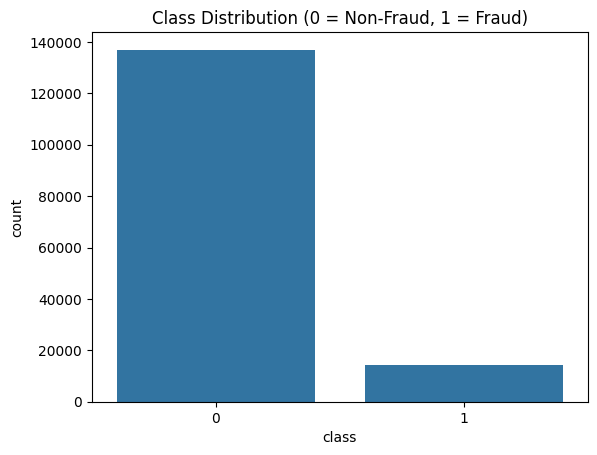

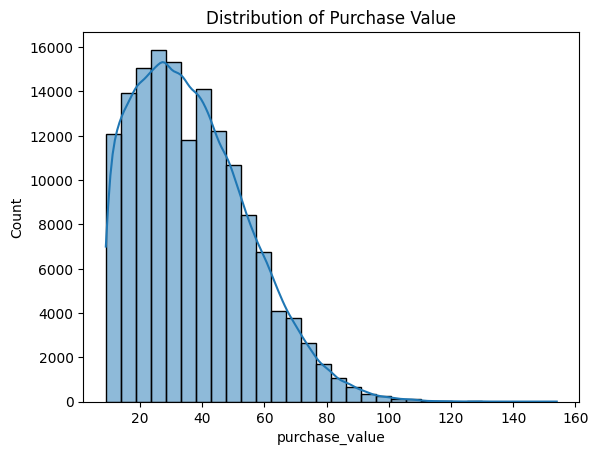

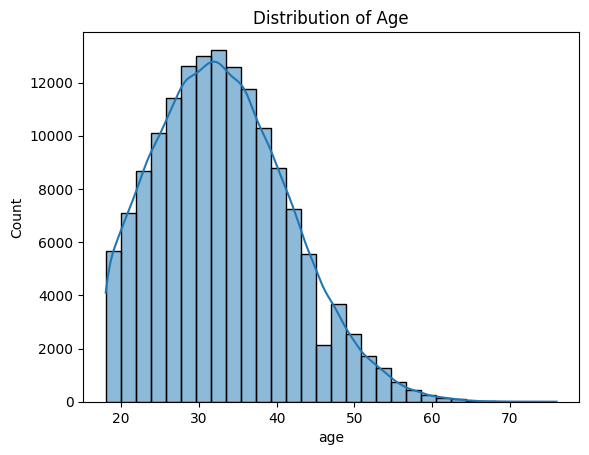

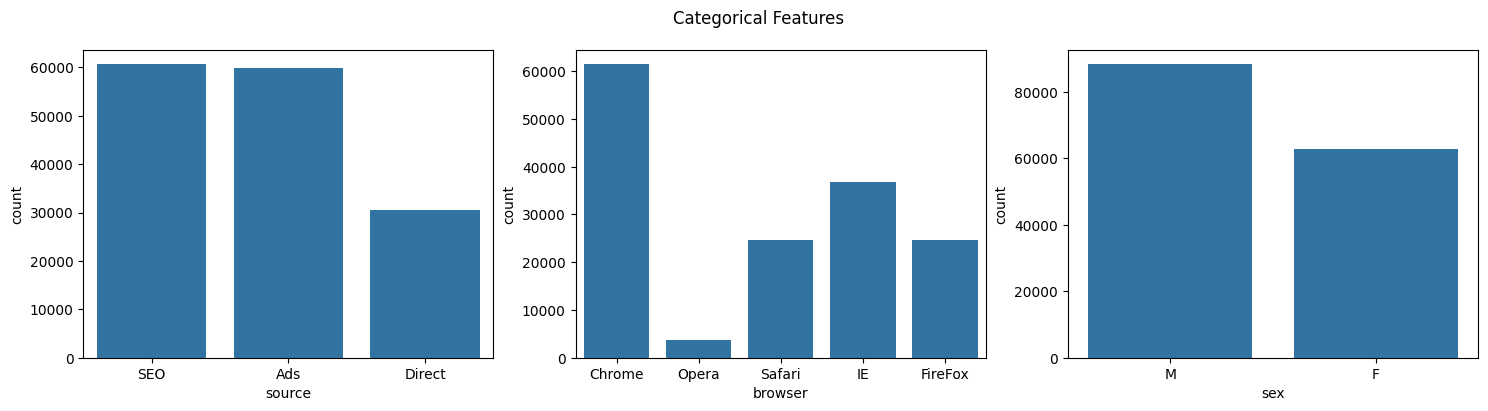

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Class distribution (fraud vs non-fraud)
sns.countplot(data=fraud_df, x='class')
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.show()

# 2. Purchase Value distribution
sns.histplot(data=fraud_df, x='purchase_value', bins=30, kde=True)
plt.title('Distribution of Purchase Value')
plt.show()

# 3. Age distribution
sns.histplot(data=fraud_df, x='age', bins=30, kde=True)
plt.title('Distribution of Age')
plt.show()

# 4. Categorical breakdown: Source, Browser, Sex
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.countplot(data=fraud_df, x='source', ax=axs[0])
sns.countplot(data=fraud_df, x='browser', ax=axs[1])
sns.countplot(data=fraud_df, x='sex', ax=axs[2])
plt.suptitle('Categorical Features')
plt.show()


Bivariate Analysis (Features vs Fraud)

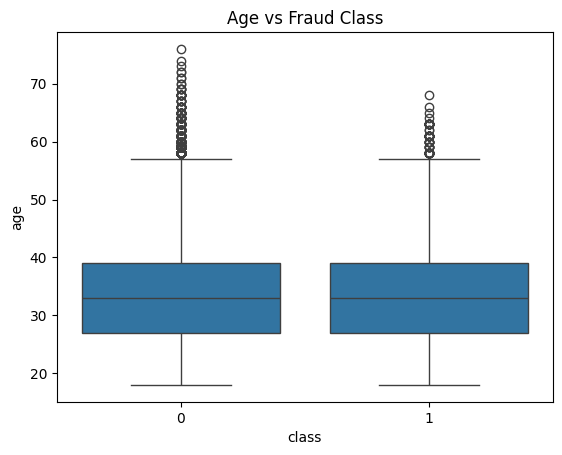

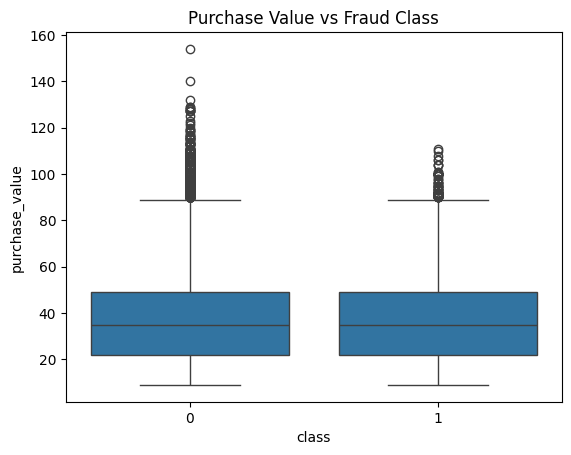

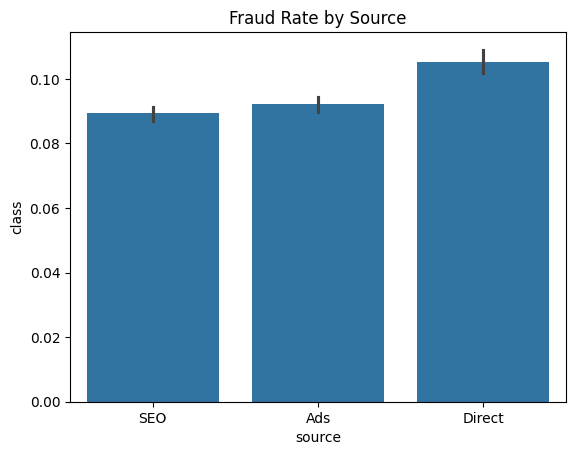

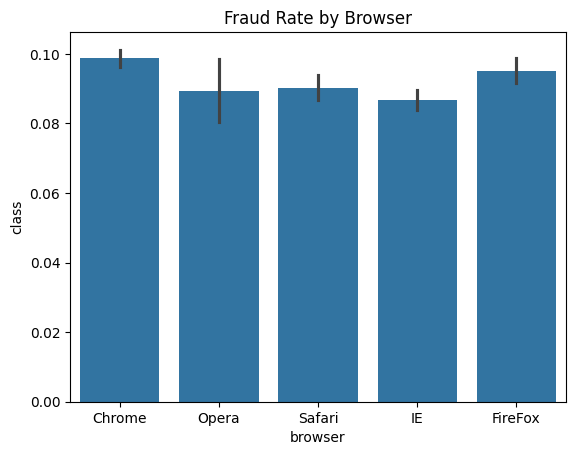

In [5]:
# 1. Age vs Fraud
sns.boxplot(data=fraud_df, x='class', y='age')
plt.title('Age vs Fraud Class')
plt.show()

# 2. Purchase Value vs Fraud
sns.boxplot(data=fraud_df, x='class', y='purchase_value')
plt.title('Purchase Value vs Fraud Class')
plt.show()

# 3. Source vs Fraud Rate
sns.barplot(data=fraud_df, x='source', y='class')
plt.title('Fraud Rate by Source')
plt.show()

# 4. Browser vs Fraud Rate
sns.barplot(data=fraud_df, x='browser', y='class')
plt.title('Fraud Rate by Browser')
plt.show()


In [6]:
ip_df = pd.read_csv("../data/IpAddress_to_Country.csv")
print(ip_df.head())


   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China


Convert IP Addresses to Integer Format

In [7]:
# Convert to integer
fraud_df['ip_address'] = fraud_df['ip_address'].astype('int')
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype('int')
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype('int')
 

Perform the IP Range Merge

In [8]:
# Step: Sort IP ranges
ip_df = ip_df.sort_values(by='lower_bound_ip_address')

# Merge using interval logic
def map_ip_to_country(user_ip):
    match = ip_df[(ip_df['lower_bound_ip_address'] <= user_ip) & 
                  (ip_df['upper_bound_ip_address'] >= user_ip)]
    if not match.empty:
        return match.iloc[0]['country']
    return 'Unknown'

# Apply to fraud_df
fraud_df['country'] = fraud_df['ip_address'].apply(map_ip_to_country)

print(fraud_df[['ip_address', 'country']].head())

   ip_address        country
0   732758368          Japan
1   350311387  United States
2 -2147483648  United States
3 -2147483648  United States
4   415583117  United States


Time-Based Features

In [9]:
# Extract hour and day of the week
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek  # Monday = 0, Sunday = 6

# Time since signup in hours
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600


Transaction Frequency

In [10]:
# Number of transactions by user
fraud_df['user_transaction_count'] = fraud_df.groupby('user_id')['user_id'].transform('count')

# Time since last transaction per user (sorted first)
fraud_df = fraud_df.sort_values(by=['user_id', 'purchase_time'])
fraud_df['prev_purchase_time'] = fraud_df.groupby('user_id')['purchase_time'].shift(1)
fraud_df['time_since_last_txn'] = (fraud_df['purchase_time'] - fraud_df['prev_purchase_time']).dt.total_seconds() / 3600


In [11]:
print(fraud_df[['purchase_time', 'hour_of_day', 'day_of_week', 'time_since_signup']].head())


             purchase_time  hour_of_day  day_of_week  time_since_signup
116708 2015-02-21 10:03:37           10            5         990.273333
15108  2015-09-26 21:32:16           21            5        2788.855278
46047  2015-08-13 11:53:07           11            3        1852.000278
67650  2015-05-20 23:06:42           23            2         103.136111
109067 2015-03-04 20:56:37           20            2        1286.523611


Apply SMOTE

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np

# ========= Step 1: Set up your feature matrix and target =========
X = fraud_df.drop(columns=['class'])  # or rename to match your target column
y = fraud_df['class']

# ========= Step 2: Identify columns =========
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# ========= Step 3: Train/Test Split =========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========= Step 4: Build preprocessing pipelines =========
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ========= Step 5: Combine with SMOTE in pipeline =========
pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42))
])

# ========= Step 6: Fit/transform training, transform test =========
X_train_bal, y_train_bal = pipeline.fit_resample(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# ========= Step 7: Output check =========
print("Before SMOTE:\n", y_train.value_counts(normalize=True))
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts(normalize=True))
print("Balanced training shape:", X_train_bal.shape)
print("Processed test shape:", X_test_processed.shape)


c:\Users\mijuu\Documents\ML-FraudScan\.venv\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['time_since_last_txn']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\mijuu\Documents\ML-FraudScan\.venv\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['time_since_last_txn']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Before SMOTE:
 class
0    0.906352
1    0.093648
Name: proportion, dtype: float64
After SMOTE:
 class
0    0.5
1    0.5
Name: proportion, dtype: float64
Balanced training shape: (219136, 111544)
Processed test shape: (30223, 111544)


c:\Users\mijuu\Documents\ML-FraudScan\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
# Remove column that caused missing values warning
if 'time_since_last_txn' in numerical_cols:
    numerical_cols.remove('time_since_last_txn')


In [15]:
import joblib
import os

# Make sure the folder exists
os.makedirs('../data/preprocessed', exist_ok=True)

# Save resampled training data
joblib.dump(X_train_bal, '../data/preprocessed/X_train_bal.pkl')
joblib.dump(y_train_bal, '../data/preprocessed/y_train_bal.pkl')

# Save processed test data
joblib.dump(X_test_processed, '../data/preprocessed/X_test_processed.pkl')
joblib.dump(y_test, '../data/preprocessed/y_test.pkl')

# Save the preprocessor pipeline
joblib.dump(preprocessor, '../data/preprocessed/fraud_preprocessor.pkl')

print("✅ Preprocessed data saved to '../data/preprocessed/'")


✅ Preprocessed data saved to '../data/preprocessed/'
